# Testing Binary Structure Models on Multivariate Data

Much of this notebook is adapted from notebooks/bivariate-categorical/03_meta_learning.ipynb

In [1]:
import sys
sys.path.insert(0, '../..')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange as tnrange

from cs330.data_generators.multivariate_categorical import MultiCategorical
from cs330.data_generators.causal_graph import CausalGraph
from cs330.models.augmented_binary_models import *
from cs330.models.augmented_binary_model_trainer import *

#from models import StructuralModel

In [3]:
# Trial Setup
if True:
    TRIAL_ID = "binary_with_confounder"
    N = 10
    M = 3

    # Create graph and data generator
    data_gen = MultiCategorical(N, M)
    data_gen.graph.B = np.array([
        [0, 0, 0],
        [1, 0, 0],
        [1, 0, 0]
    ])
    # Determine node indices to compare
    A = 1
    B = 2

if False:
    TRIAL_ID = "binary_with_collider"
    N = 10
    M = 3

    # Create graph and data generator
    data_gen = MultiCategorical(N, M)
    data_gen.graph.B = np.array([
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 0]
    ])
    # Determine node indices to compare
    A = 0
    B = 1

In [4]:
# Create Model
# model = StructuralModel(N, dtype=torch.float64)
model = CauseOnlyBinaryStructureModel(N, M, A, B)

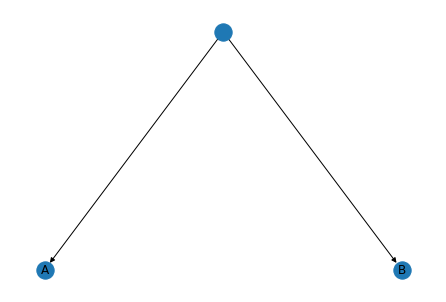

In [5]:
# Save labeled graph image
data_gen.graph.visualize(labels={A: "A", B: "B"})
plt.savefig(f"{TRIAL_ID}.graph.png")

In [6]:
model_handler = AugmentedBinaryModelTrainer(
    data_gen, model,
    inner_lr = 1e-1,
    outer_lr = 1e-2,
    transfer_episode_count = 500,
    transfer_episode_gradient_steps = 20,
    transfer_episode_batch_size = 50,
    pretrain_episode_batch_size = 500
)

In [7]:
# Training constants
num_runs = 10

In [8]:
structure_likelihoods = torch.zeros((num_runs, model_handler.transfer_episode_count, model_handler.hypothesis_count()))

for i in tnrange(num_runs):
    # Step 1: Sample a joint distribution before intervention
    data_gen.reset_all_distributions()

    model_handler.reset()

    # Step 1.5: Save samples to pretrain hypothesis models before each transfer training iteration
    # - Done automatically on first iteration, triggered manually for multiple runs of the same graph
    model_handler.pretrain_samples = data_gen.sample(model_handler.pretrain_episode_batch_size)

    # Step 2: Train structure model over multiple transfer episodes
    model_handler.train_structure()

    # Update logs
    structure_likelihoods[i, :, :] = model_handler.structure_likelihoods

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [9]:
# Setup for plotting results of binary test

hypothesis_curves = {}
for i in range(model_handler.hypothesis_count()):
    name = model_handler.structural_model.hypothesis_names()[i]
    curves = structure_likelihoods[:, :, i]
    hypothesis_curves[name] = curves

HYPOTHESIS_COLORS = ['g', 'r', 'b', 'y']

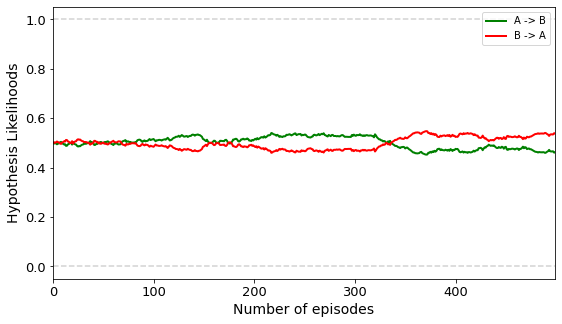

In [10]:
# Plot median structure likelihood history

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(1, 1, 1)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.axhline(1, c='lightgray', ls='--')
ax.axhline(0, c='lightgray', ls='--')

counter = 0
for name, curves in hypothesis_curves.items():
    ax.plot(np.percentile(curves, 50, axis=0), lw=2, color=HYPOTHESIS_COLORS[counter], label=name)
    counter += 1

ax.legend()

ax.set_xlim([0, model_handler.transfer_episode_count - 1])
ax.set_xlabel('Number of episodes', fontsize=14)
ax.set_ylabel("Hypothesis Likelihoods", fontsize=14)

#plt.savefig(f"{TRIAL_ID}_median_alphas.png")
plt.show()

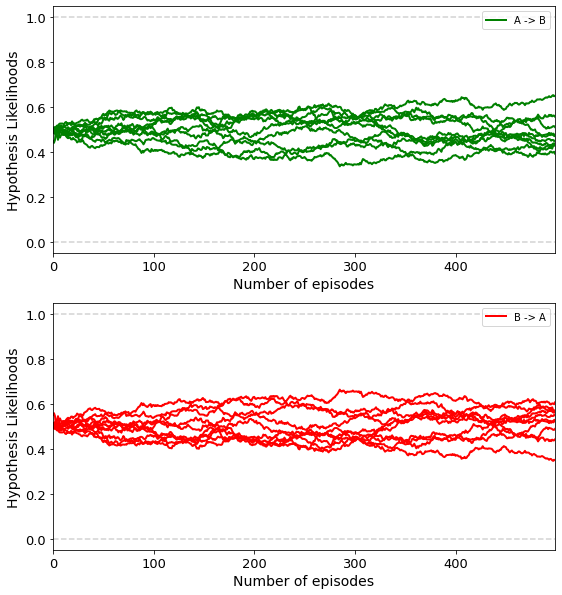

In [14]:
# Plot all structure likelihood histories over multiple runs

fig, axarr = plt.subplots(model_handler.hypothesis_count(), 1, figsize=(9, 5 * model_handler.hypothesis_count()))

counter = 0
for name, curves in hypothesis_curves.items():
    ax = axarr[counter]
    
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.axhline(1, c='lightgray', ls='--')
    ax.axhline(0, c='lightgray', ls='--')

    for curve_ind in range(curves.shape[0]):
        if curve_ind == 0:
            ax.plot(curves[curve_ind].numpy(), lw=2, color=HYPOTHESIS_COLORS[counter], label=name)
        else:
            ax.plot(curves[curve_ind].numpy(), lw=2, color=HYPOTHESIS_COLORS[counter])

    ax.legend()
    ax.set_xlim([0, model_handler.transfer_episode_count - 1])
    ax.set_xlabel('Number of episodes', fontsize=14)
    ax.set_ylabel("Hypothesis Likelihoods", fontsize=14)

    counter += 1

#plt.savefig(f"{TRIAL_ID}_all_alphas.png")
plt.show()